In [1]:
## Python imports
import h5py as h5
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os

## respic imports
from rsrespic.fields import fields
from rsrespic.particles import particles 
from rsrespic.solvers import solvers
from rsrespic.utilities import utilities, constants, diagnostics

## lattice import for respic 
from respic_fodo import octo_respic as fodo_cell
 

## constants 
from scipy.constants import c as c_mks
from scipy.constants import elementary_charge as q_mks 
from scipy.constants import m_p as m_p_mks

q = constants.cgs_constants['q']
c = constants.cgs_constants['c']
m_e = constants.cgs_constants['m_e']
m_p = constants.cgs_constants['m_p']
pi = np.pi
c_mks = c / 100.


def compute_tunes(s, beta_x, beta_y, number_of_turns):
    phi_x = np.trapz(1. / beta_x, x = s) / number_of_turns
    phi_y = np.trapz(1. / beta_y, x = s) / number_of_turns

    nux = 1. / (2. * np.pi) * phi_x
    nuy = 1. / (2. * np.pi) * phi_y
    return nux, nuy


# Warning! This code requires elegant, sddstools, and is only implemented for protons

* This generates a fodo lattice

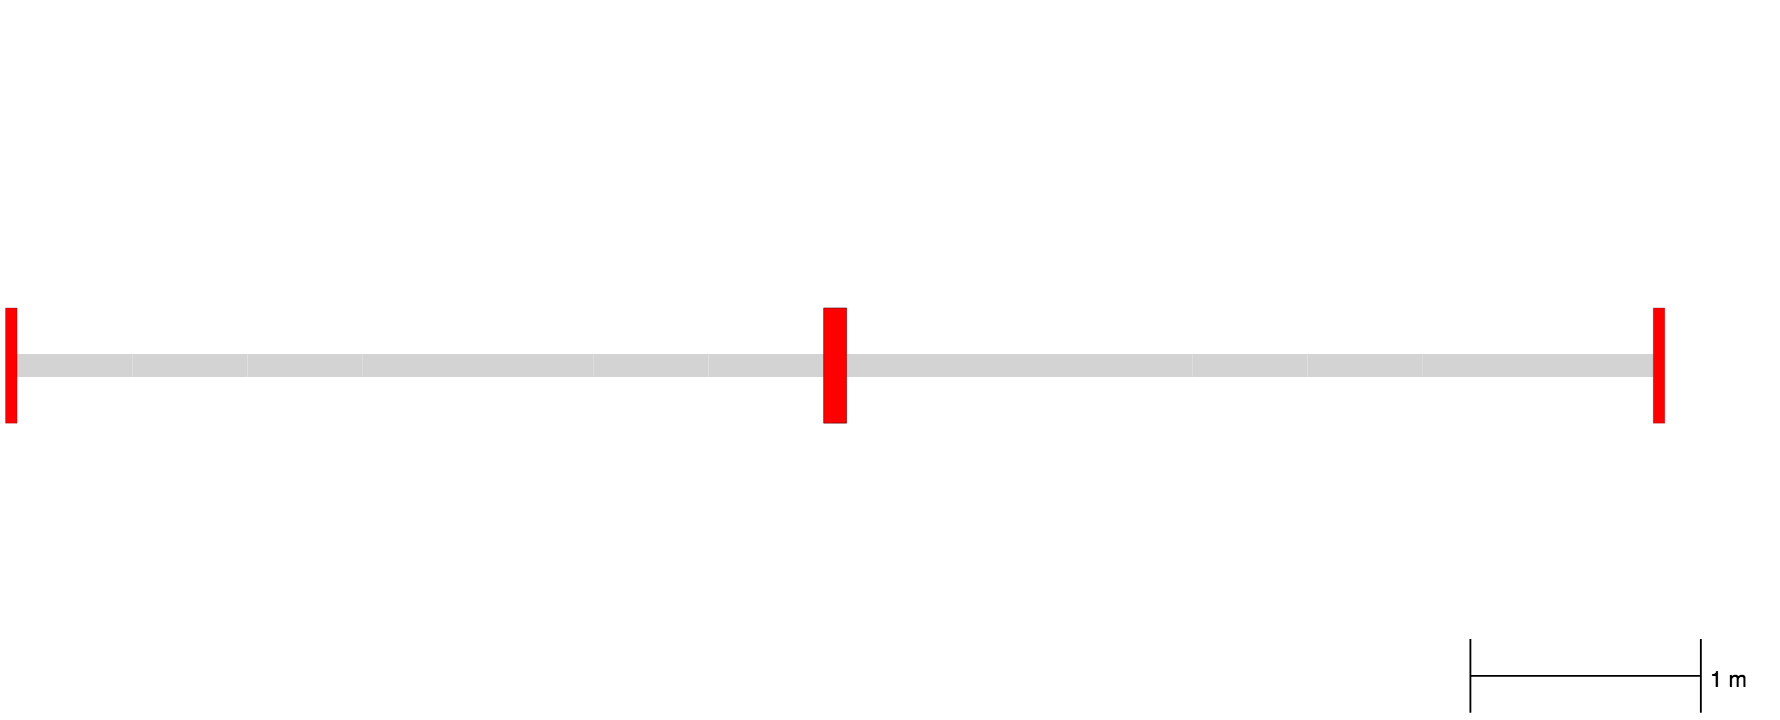


In [2]:
## Global parameters for the simulation, energy is kinetic, drift length is in meters

E = 1.0e6
mc2 = m_p_mks * c_mks**2 / q_mks
bgz = np.sqrt((E / mc2 + 1) ** 2. - 1.)


In [14]:
## Setup input file for elegant 
p_central = bgz
emit_x = 5.0e-5
emit_y = 5.0e-5
number_of_turns = 300
number_of_ele_turns = 1

parameter_names = ['p_central_param', 'emit_x_param', 'emit_y_param', 'number_of_turns']


parameter_values = [p_central, emit_x, emit_y, number_of_ele_turns]


with open('elegant_resonance/octo_ele.txt', 'r') as file : filedata = file.read()
for i in range(0, len(parameter_names)):
    filedata = filedata.replace(parameter_names[i], str(parameter_values[i]))
with open('elegant_resonance/octo.ele', 'w') as file: file.write(filedata)

## Run elegant
p = subprocess.Popen(['elegant', 'octo.ele'], cwd='elegant_resonance/')
p.wait()


0

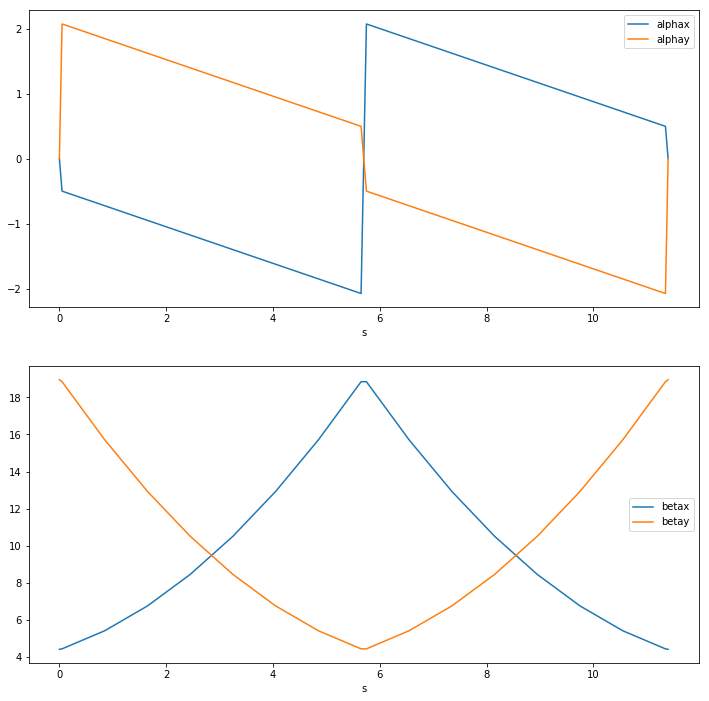

0.21488237882664088 0.21486995259765704 1.7190093256971917


In [15]:
## Verify the solution for elegant

## Read beam from elegant to generate distribution for respic
fn = 'elegant_resonance/matched_octo.bun'
column_names = ['x', 'xp', 'y', 'yp']
dist = utilities.read_sdds_columns(fn, column_names)
#utilities.plot_elegant_beam(dist)

## generate beam for respic
beam = np.column_stack([dist.x, dist.xp, dist.y, dist.yp])
np.savetxt('elegant_distribution.txt', beam, delimiter = ',')

## Read matching solution from elegant for plotting
fn_beam_sig = 'elegant_resonance/matched_octo.sig'
fn_beam_twi = 'elegant_resonance/matched_octo.twi'

column_names = ['s', 'betaxBeam', 'alphaxBeam', 'betayBeam', 'alphayBeam', 'Sx', 'Sy', 'Sxp', 'Syp']
beam_twiss = utilities.read_sdds_columns(fn_beam_sig, column_names)
beam_twiss = utilities.read_sdds_parameter(fn_beam_twi, ['nux', 'nuy'], beam_twiss)
nux_ele, nuy_ele = utilities.compute_tunes(beam_twiss, number_of_ele_turns)
utilities.plot_twiss_sdds(beam_twiss, flag = 'Beam')

print nux_ele, nuy_ele, 4.* nux_ele + 4.*nuy_ele



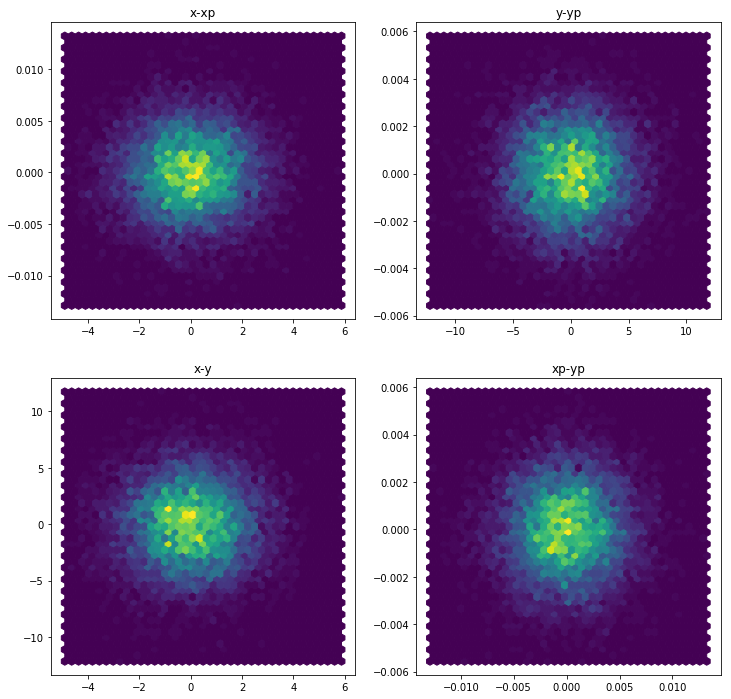

In [16]:
## Setup respic simulation 
charge_per_cm_mks = 4.0e-12  # Charge per cm (make sure to not set to zero because of particle weights)
Q = constants.charge_mks_to_cgs(charge_per_cm_mks)
n_particles = 100000
s = 0

## Load the distribution from elegant
distribution = particles.distribution()
distribution.import_from_file(fn = 'elegant_distribution.txt')

respic_beam = particles.particles_2D_delta(distribution, bunch_charge = Q,
                                            species_mass = m_p, K_e = E)


## Define the fields
sigma_x = np.std(respic_beam.x)
sigma_y = np.std(respic_beam.y)

L_0 = 40. * sigma_x ## Half the domain size
L_min = L_0 / 40. ## minimum wavelength to resolve

my_fields = fields.cartesian_2D(L_x = 20.0 * sigma_x, L_y = 20.0 * sigma_y,
    L_x_min = sigma_x / 2., L_y_min = sigma_y / 2.)


## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()
my_fields.register_solver(field_solver)


## Diagnostic setup
respic_diag = diagnostics.bunch_statistics()
dumper = diagnostics.particle_dumper(file_name='octo_respic_sc_26mar2.h5')

## Load the maps
maps = solvers.symplectic_maps()

utilities.plot_rspic_beam(respic_beam)

## Construct the lattice using the fodo cell defined in the geometry file
lattice = fodo_cell() ## charge sign conversion



In [ ]:
### Setup the number of passes and the initial pass number
turn_number = 0
turns = number_of_turns

## Update the diagnostics at the beginning of the simulatoin
respic_diag.update(s, respic_beam)
dumper.dump(respic_beam, s)

## Run the simluation 
while turn_number < turns:
    s = lattice.one_turn_map(maps, my_fields, respic_beam, respic_diag, s)
    dumper.dump(respic_beam, s)
    
    if turn_number % 10 == 0:
        print 'turn_number: ',turn_number
        
    turn_number += 1
    

dumper.close()
    

turn_number:  0


In [7]:
## Load data from synergia run
syner_file = h5.File('diagnostics.h5')
s_syn = np.asarray(syner_file['s'])
xx_syn = syner_file['mom2'][0,0,:]
xxp = syner_file['mom2'][0,1,:]
xpxp = syner_file['mom2'][1,1,:]
emit_x = np.sqrt(xx_syn*xpxp - xxp**2)

beta_x_syn = xx_syn / emit_x

yy_syn = syner_file['mom2'][2,2,:]
yyp = syner_file['mom2'][2,3,:]
ypyp = syner_file['mom2'][3,3,:]
emit_y = np.sqrt(yy_syn*ypyp - yyp**2)

beta_y_syn = yy_syn / emit_y



In [8]:


respic_diag.compute_tunes(1)
print 'elegant', nux_ele, nuy_ele, 4. * nuy_ele + 4.*nux_ele

print 'respic', respic_diag.nux, respic_diag.nuy, 4. * respic_diag.nux + 4. * respic_diag.nuy
nux_s, nuy_s = compute_tunes(s_syn, beta_x_syn, beta_y_syn, 1)

print 'synergia', nux_s, nuy_s, 4.*nux_s + 4.*nuy_s


elegant 0.12859135037892977 0.12858770746219017 1.0287162313644798
respic 0.12402715651365916 0.123820097220131 0.9913890149351606
synergia 0.12342748127047747 0.12274146308178958 0.9846757774090682


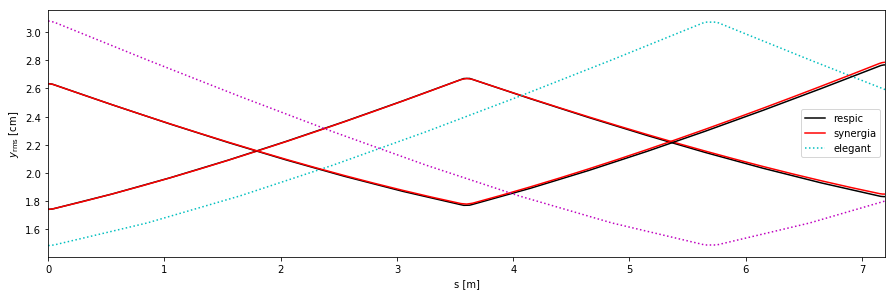

In [13]:
## Plot the result of respic and elegant for zero-current fodo cell
x_key = 's'

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(respic_diag.get_parameter('s') / 100., respic_diag.get_parameter('rms_x'), '-k')
plt.plot(s_syn, np.sqrt(xx_syn) * 100., '-r')
plt.plot(beam_twiss.s, beam_twiss.Sx * 100, ':c')


plt.plot(respic_diag.get_parameter('s')/ 100., respic_diag.get_parameter('rms_y'), '-k')
plt.plot(s_syn, np.sqrt(yy_syn) * 100., '-r')
plt.plot(beam_twiss.s, beam_twiss.Sy * 100, ':m')
plt.ylabel(r'$y_\mathrm{rms}$ [cm]')

plt.legend(['respic', 'synergia', 'elegant'])
plt.xlabel(x_key + ' [m]')
plt.xlim([0,np.max(s_syn)])

plt.savefig('synergia_respic_fodo.pdf')

plt.show()




In [10]:
print respic_beam.weight * n_particles 

p = respic_beam.gamma * respic_beam.beta * c_mks * m_p_mks
e = q_mks

print respic_beam.gamma

print 4.0 * p / e


249660004.565
1.00106579047
0.5781422155190236
